Forecast stock price for a horizon of 21 days.
- No transformation of data
- Features: AdjClose_Lag1, AdjClose_Lag2, AdjClose_Lag3

How to forecast future 21 days: recursive forecasting
- Train model using training set: 1008 samples
- Apply model to forecast t+1 day's stock price, integrate the forecasted price to feature and then forecast the t+2 day... till the t+21 day's stock price is forecasted

## Load packages and parameter configuration

In [27]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from datetime import date
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")

start_date = '2013-01-02' # Data start date (inclusive)
end_date = '2019-01-01' # Data end date (exclusive)
path = f'./data/VTI_{start_date}_{end_date}' # Path of downloaded data file
N = 3 # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
H = 21 # 21-day horizon

## Load data

In [3]:
df_train = pd.read_csv(f'{path}/df_train.csv')
df_cv = pd.read_csv(f'{path}/df_cv.csv')
df_test = pd.read_csv(f'{path}/df_test.csv')

In [9]:
# Concat train and cv dataset, since no params tuning in this notebook
df_train = pd.concat([df_train, df_cv])

In [34]:
# Convert data type
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_test['Date'] = pd.to_datetime(df_test['Date'])

In [35]:
# Split into X and y
features = ['AdjClose_Lag1','AdjClose_Lag2','AdjClose_Lag3']
target = 'AdjClose'
X_train = df_train[features]
y_train = df_train[target]

X_test = df_test[features].iloc[:H,:] # 21-day horizon
y_test = df_test[target][:H]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1206, 3)
(1206,)
(21, 3)
(21,)


## Initial model training

In [14]:
n_estimators = 100             
max_depth = 3                  
learning_rate = 0.1            
min_child_weight = 1           
subsample = 1                  
colsample_bytree = 1           
colsample_bylevel = 1          
  
model_seed = 100

In [15]:
# Initiate the model
model = XGBRegressor(objective ='reg:squarederror',
                     seed=model_seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel)


# Train the regressor
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None, colsample_bylevel=1,
             colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [16]:
def evaluate_model(y_true, y_pred):
    """
    Input: true y and predicted y
    Return: Dataframe of RMSE and MAPE
    """
    rmse = mean_squared_error(y_true, y_pred)**0.5 # root mean squared error
    mape = mean_absolute_percentage_error(y_true, y_pred) # mean absolute percentage error
    
    evaluation = pd.DataFrame({'RMSE':[rmse],'MAPE':[mape]})
    return evaluation

### Performance on training set

In [17]:
# Predict on train set
y_pred = model.predict(X_train)

evaluate_model(y_train, y_pred)

,RMSE,MAPE
0,0.561846,0.004583


### Performance on test set

In [23]:
def predict_recursive(model, features, N, H):
    """
    Do recursive forecasting
    Inputs
        model   : the trained model
        features: numpy array of shape (N,). The starting point of test set to do resursive forecasting
        N       : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H       : forecast horizon
    Outputs
        Times series of predictions. Numpy array of shape (H,).
    """
    forecast = features.copy()
    for h in range(H):
        fcst = model.predict(forecast[-N:].reshape(1,-1))
        forecast = np.append(forecast, fcst)

    return forecast[-H:]

In [24]:
# 3 lags of AdjClose is the starting point of test set recursive forecasting
features_for_test = y_train[-N:].to_numpy().reshape(1,-1)

In [30]:
y_pred = predict_recursive(model, features_for_test, N, H)

In [31]:
# Predict on test set
y_pred = model.predict(X_test)

evaluate_model(y_test, y_pred)

,RMSE,MAPE
0,1.004683,0.00748


In [37]:
# Create dataframe to store forecast data
df_forecast_test = pd.DataFrame({'Date':df_test['Date'][:H],
                                'Forecast':y_pred})

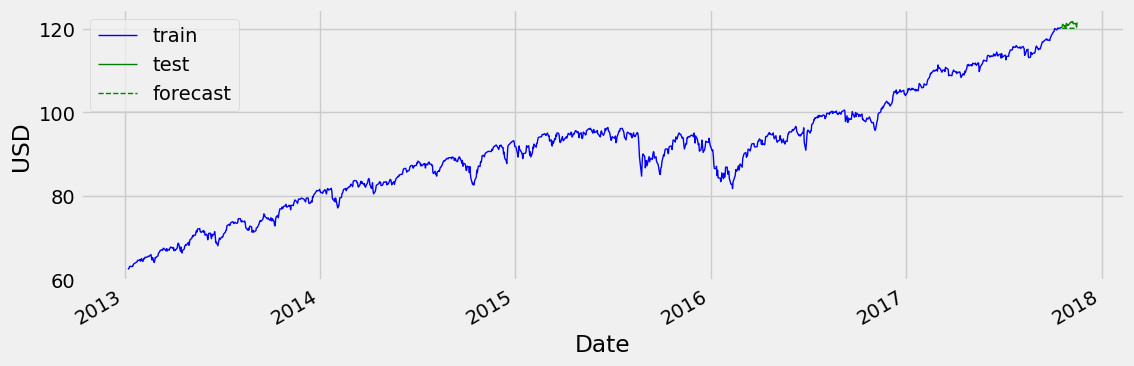

In [38]:
fig, ax = plt.subplots(figsize=(12,4))

df_train.plot(x='Date', y='AdjClose', style='b', linewidth=1, ax=ax)
df_test.iloc[:H,:].plot(x='Date', y='AdjClose', style='g', linewidth=1, ax=ax)
df_forecast_test.plot(x='Date', y='Forecast', style='g', linestyle='dashed', linewidth=1, ax=ax)

ax.legend(['train','test','forecast'])
ax.set_xlabel('Date')
ax.set_ylabel('USD')

plt.show()

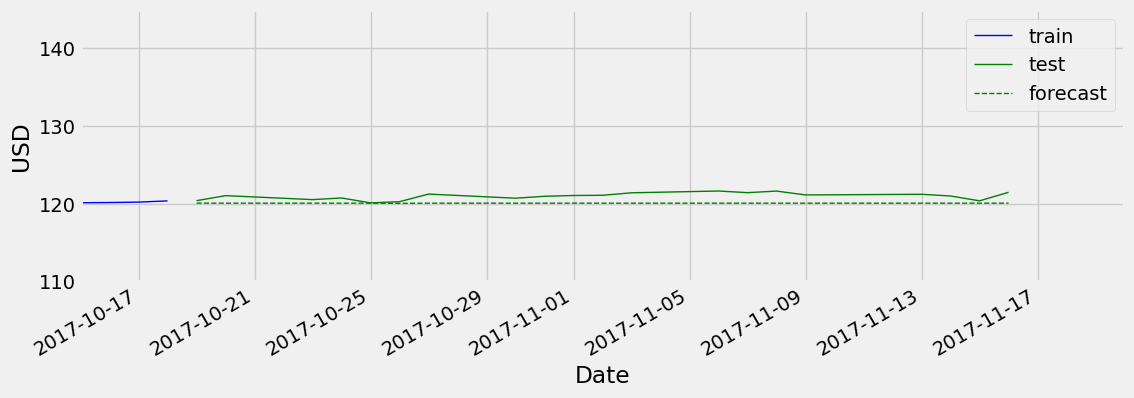

In [40]:
fig, ax = plt.subplots(figsize=(12,4))

df_train.plot(x='Date', y='AdjClose', style='b', linewidth=1, ax=ax)
df_test.iloc[:H,:].plot(x='Date', y='AdjClose', style='g', linewidth=1, ax=ax)
df_forecast_test.plot(x='Date', y='Forecast', style='g', linestyle='dashed', linewidth=1, ax=ax)

ax.legend(['train','test','forecast'])
ax.set_xlabel('Date')
ax.set_ylabel('USD')
ax.set_xlim([date(2017, 10, 15), date(2017, 11, 20)])
ax.set_ylim(110, 145)

plt.show()